In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/analyzing-credit-card-spending-habits-in-india/Credit card transactions - India - Simple.csv
/kaggle/input/newdata/Credit card transactions.csv


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Importing the dataset
data=pd.read_csv("/kaggle/input/newdata/Credit card transactions.csv")

# **Checking the dataset**

In [43]:
# Check the size of the dataset
data.shape


(26052, 7)

This dataset has 26052 Rows and 7 Columns

In [44]:
# Get top 5 rows
data.head()

,index,City,Date,Card Type,Exp Type,Gender,Amount
0,0,"Delhi, India",29-Oct-14,Gold,Bills,F,82475
1,1,"Greater Mumbai, India",22-Aug-14,Platinum,Bills,F,32555
2,2,"Bengaluru, India",27-Aug-14,Silver,Bills,F,101738
3,3,"Greater Mumbai, India",12-Apr-14,Signature,Bills,F,123424
4,4,"Bengaluru, India",5-May-15,Gold,Bills,F,171574


Column Names are:
* index - index
* City - The city in which the transaction took place
* Date - The date of the transaction
* Card Type - The type of credit card used for the transaction (Gold, Platinum, Silver, Signature)
* Exp Type - The type of expense associated with the transaction (Bills, Food, Entertainment, Grocery, Fuel, Travel)
* Gender - The gender of the cardholder (Male, Female)
* Amount - The amount of the transaction

In [45]:
# Check for null values
data.isnull().sum()

index        0
City         0
Date         0
Card Type    0
Exp Type     0
Gender       0
Amount       0
dtype: int64

There is no null values


In [46]:
# Checking for duplicate
data.duplicated().sum()

0

There is no duplicates


## **Date Feature Engineering**

In [47]:
# Spliting City into City and Country and taking only City
data["City"]=data["City"].str.split(",",expand=True)[0]

----

In [48]:
# Extract Month and Day from the datetime object
data["Date"] = pd.to_datetime(data["Date"], format='%d-%b-%y')
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.dayofweek
data["MonthName"] = data["Date"].dt.month_name()
data["DayName"] = data["Date"].dt.day_name()
data["Year"] = data["Date"].dt.year
data.head()


,index,City,Date,Card Type,Exp Type,Gender,Amount,Month,Day,MonthName,DayName,Year
0,0,Delhi,2014-10-29,Gold,Bills,F,82475,10,2,October,Wednesday,2014
1,1,Greater Mumbai,2014-08-22,Platinum,Bills,F,32555,8,4,August,Friday,2014
2,2,Bengaluru,2014-08-27,Silver,Bills,F,101738,8,2,August,Wednesday,2014
3,3,Greater Mumbai,2014-04-12,Signature,Bills,F,123424,4,5,April,Saturday,2014
4,4,Bengaluru,2015-05-05,Gold,Bills,F,171574,5,1,May,Tuesday,2015


In [49]:
print(f"Number of unique values in Day column: {data['Day'].unique().size}")
print(f"Number of unique values in Month column: {data['Month'].unique().size}")

Number of unique values in Day column: 7
Number of unique values in Month column: 12


Since this will also contribute to the complexity of the model, We will reduce the model complexity using cyclic encoding

### Cyclic encoding

Why Cyclic Encoding? <br>
* Unlike one-hot encoding, cyclical encoding ensures that adjacent cyclical values retain their relationships (e.g., December is adjacent to January). <br>
* Cyclical encoding requires fewer dimensions than one-hot encoding, leading to more efficient data representation

In [50]:
def encodeCyclic(value, maxValue):
    radians = 2 * np.pi * value / maxValue
    return np.sin(radians), np.cos(radians)

data['MonthSin'], data['MonthCos'] = zip(*data['Month'].apply(lambda x: encodeCyclic(x-1, 12)))

data['DaySin'], data['DayCos'] = zip(*data['Day'].apply(lambda x: encodeCyclic(x, 7)))

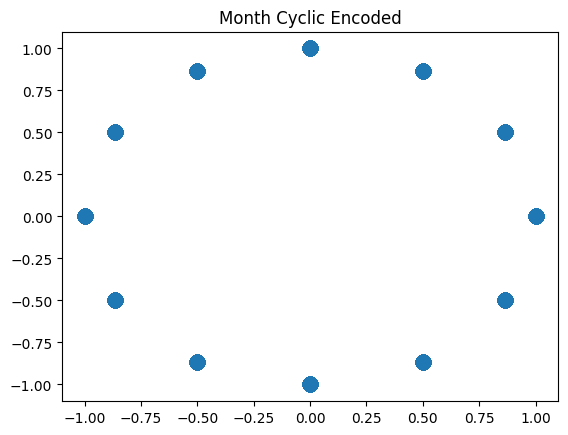

In [51]:
plt.plot(data['MonthSin'],data['MonthCos'],marker = 'o',markersize = 10, linewidth = 0)
plt.title('Month Cyclic Encoded')
plt.show()

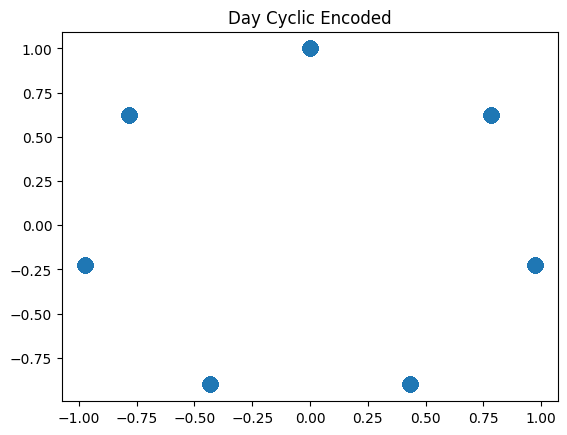

In [52]:
plt.plot(data['DaySin'],data['DayCos'],marker = 'o',markersize = 10, linewidth = 0)
plt.title('Day Cyclic Encoded')
plt.show()

----

In [53]:
print(f"Number of unique values in City column: {data['City'].unique().size}")

Number of unique values in City column: 986


Since there are 986 values in the city column it will increase the complexity of the model even more leading to overfitting. To avoid that we are going to use city encoding into tiers.

### Encoding Cities into Tiers

The spending paterns are affected by the city/town in which the customer lives. For example a person from highly developed city with high gross income per person will use thier credit card more, meanwhile a person from under developed city may not even know what a credit card is.

The classification of Indian cities is a ranking system used by the Government of India to allocate House Rent Allowance (HRA) to public servants employed in cities in India. India has been divided into various categories by the **Pay Commission**. There has been multiple types of classifications.

**Tier Classification:** RBI classifies the cities under Tier 1-6 categories based on their population.
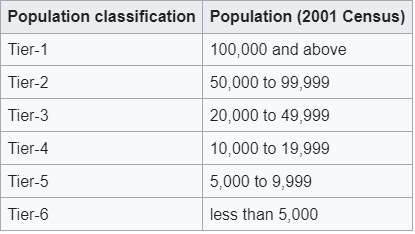

**Rural, Urban classifications:** <br>
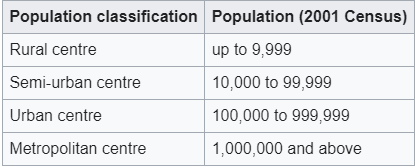

Before 2008, there were two categories in which the cities were classified in India. This was called the Historical classification and the cities were classified before the Sixth Pay Commission's recommendations. 

**HRA classification:**

Under the recommendation of the Seventh Central Pay Commission, the CCA classification was abolished in 2008. The earlier HRA classification of cities was changed from 
*     A-1 to X 
*     A, B-1, and B-2 to Y 
*     C and unclassified cities to Z

X, Y, and Z are more commonly known as Tier-1, Tier-2, and Tier-3 cities,

There are eight X cities and 97 Y cities in India. 
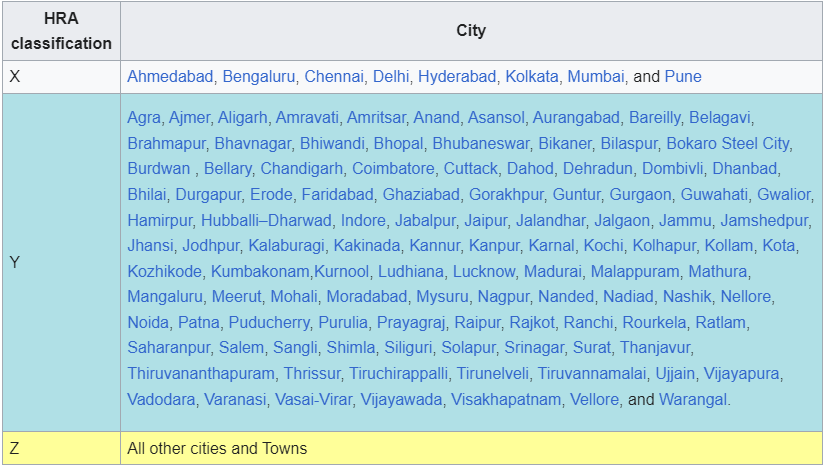

References -
* https://en.wikipedia.org/wiki/Classification_of_Indian_cities
* https://www.jagranjosh.com/general-knowledge/explained-classification-of-indian-cities-into-tiers-reason-categorization-and-other-details-1629375309-1

Suggestion - Dr. Damayanthi

In [54]:
t1=['Ahmedabad', 'Bengaluru', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai', 'Pune']
t2=['Ajmer','Aligarh','Amravati','Amritsar','Anand','Asansol','Aurangabad','Bareilly','Belagavi','Bhavnagar','Bhiwandi','Bhopal','Bhubaneswar','Bikaner','Bilaspur','Bokaro Steel City','Burdwan','Chandigarh','Coimbatore','Cuttack','Dahod','Dehradun','Dombivli','Dhanbad','Bhilai','Durgapur','Erode','Faridabad','Ghaziabad','Gorakhpur','Guntur','Gurugram','Guwahati','Gwalior','Hamirpur','Hubli-Dharwad','Indore','Jabalpur','Jaipur','Jalandhar','Jalgaon','Jammu','Jamnagar','Jamshedpur','Jhansi','Jodhpur','Kalaburagi','Kakinada','Kannur','Kanpur','Karnal','Kochi','Kolhapur','Kollam','Kozhikode','Kurnool','Ludhiana','Lucknow','Madurai','Malappuram','Mathura','Mangaluru','Meerut','Moradabad','Mysore','Nagpur','Nanded-Waghala','Nashik','Nellore','Noida','Patna','Puducherry','Purulia','Prayagraj','Raipur','Rajkot','Rajahmundry','Ranchi','Rourkela','Ratlam','Salem','Sangli','Shimla','Siliguri','Solapur','Srinagar','Surat','Thanjavur','Thiruvananthapuram','Thrissur','Tiruchirappalli','Tirunelveli','Tiruvannamalai','Ujjain','Vijayapura','Vadodara','Varanasi','Vasai-Virar','Vijayawada','Visakhapatnam','Vellore','Warangal']

def city_tier(city):
  if city in t1:
    return 'Tier-1'
  elif city in t2:
    return 'Tier-2'
  else :
    return 'Tier-3'

data['City'] = data['City'].apply(lambda x: x.split(',')[0])
data['City Tier'] = data['City'].apply(lambda x: city_tier(x))

In [55]:
print(f"Number of unique values in City column: {data['City Tier'].unique().size}")

Number of unique values in City column: 3


Now, 986 values are reduced to 3 values and this will improve the model performance.

In [56]:
data.head()

,index,City,Date,Card Type,Exp Type,Gender,Amount,Month,Day,MonthName,DayName,Year,MonthSin,MonthCos,DaySin,DayCos,City Tier
0,0,Delhi,2014-10-29,Gold,Bills,F,82475,10,2,October,Wednesday,2014,-1.000000,-1.836970e-16,0.974928,-0.222521,Tier-1
1,1,Greater Mumbai,2014-08-22,Platinum,Bills,F,32555,8,4,August,Friday,2014,-0.500000,-8.660254e-01,-0.433884,-0.900969,Tier-3
2,2,Bengaluru,2014-08-27,Silver,Bills,F,101738,8,2,August,Wednesday,2014,-0.500000,-8.660254e-01,0.974928,-0.222521,Tier-1
3,3,Greater Mumbai,2014-04-12,Signature,Bills,F,123424,4,5,April,Saturday,2014,1.000000,6.123234e-17,-0.974928,-0.222521,Tier-3
4,4,Bengaluru,2015-05-05,Gold,Bills,F,171574,5,1,May,Tuesday,2015,0.866025,-5.000000e-01,0.781831,0.623490,Tier-1


In [57]:
data.drop(columns=["Date","index"], inplace=True)

In [58]:
data

,City,Card Type,Exp Type,Gender,Amount,Month,Day,MonthName,DayName,Year,MonthSin,MonthCos,DaySin,DayCos,City Tier
0,Delhi,Gold,Bills,F,82475,10,2,October,Wednesday,2014,-1.000000,-1.836970e-16,0.974928,-0.222521,Tier-1
1,Greater Mumbai,Platinum,Bills,F,32555,8,4,August,Friday,2014,-0.500000,-8.660254e-01,-0.433884,-0.900969,Tier-3
2,Bengaluru,Silver,Bills,F,101738,8,2,August,Wednesday,2014,-0.500000,-8.660254e-01,0.974928,-0.222521,Tier-1
3,Greater Mumbai,Signature,Bills,F,123424,4,5,April,Saturday,2014,1.000000,6.123234e-17,-0.974928,-0.222521,Tier-3
4,Bengaluru,Gold,Bills,F,171574,5,1,May,Tuesday,2015,0.866025,-5.000000e-01,0.781831,0.623490,Tier-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26047,Kolkata,Silver,Travel,F,128191,6,6,June,Sunday,2014,0.500000,-8.660254e-01,-0.781831,0.623490,Tier-1
26048,Pune,Signature,Travel,M,246316,8,6,August,Sunday,2014,-0.500000,-8.660254e-01,-0.781831,0.623490,Tier-1
26049,Hyderabad,Silver,Travel,M,265019,1,4,January,Friday,2015,0.000000,1.000000e+00,-0.433884,-0.900969,Tier-1
26050,Kanpur,Silver,Travel,M,88174,9,6,September,Sunday,2014,-0.866025,-5.000000e-01,-0.781831,0.623490,Tier-2


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26052 entries, 0 to 26051
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       26052 non-null  object 
 1   Card Type  26052 non-null  object 
 2   Exp Type   26052 non-null  object 
 3   Gender     26052 non-null  object 
 4   Amount     26052 non-null  int64  
 5   Month      26052 non-null  int32  
 6   Day        26052 non-null  int32  
 7   MonthName  26052 non-null  object 
 8   DayName    26052 non-null  object 
 9   Year       26052 non-null  int32  
 10  MonthSin   26052 non-null  float64
 11  MonthCos   26052 non-null  float64
 12  DaySin     26052 non-null  float64
 13  DayCos     26052 non-null  float64
 14  City Tier  26052 non-null  object 
dtypes: float64(4), int32(3), int64(1), object(7)
memory usage: 2.7+ MB


In [60]:
data.describe()

,Amount,Month,Day,Year,MonthSin,MonthCos,DaySin,DayCos
count,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000
mean,156411.537425,6.354023,3.016621,2014.092392,0.025953,0.165944,-0.006499,0.001982
std,103063.254287,3.739676,2.006111,0.620761,0.731166,0.661228,0.706793,0.707415
min,1005.000000,1.000000,0.000000,2013.000000,-1.000000,-1.000000,-0.974928,-0.900969
25%,77120.250000,3.000000,1.000000,2014.000000,-0.866025,-0.500000,-0.781831,-0.900969
50%,153106.500000,6.000000,3.000000,2014.000000,0.000000,0.500000,0.000000,-0.222521
75%,228050.000000,10.000000,5.000000,2014.000000,0.866025,0.866025,0.781831,0.623490
max,998077.000000,12.000000,6.000000,2015.000000,1.000000,1.000000,0.974928,1.000000


In [61]:
data.head()

,City,Card Type,Exp Type,Gender,Amount,Month,Day,MonthName,DayName,Year,MonthSin,MonthCos,DaySin,DayCos,City Tier
0,Delhi,Gold,Bills,F,82475,10,2,October,Wednesday,2014,-1.000000,-1.836970e-16,0.974928,-0.222521,Tier-1
1,Greater Mumbai,Platinum,Bills,F,32555,8,4,August,Friday,2014,-0.500000,-8.660254e-01,-0.433884,-0.900969,Tier-3
2,Bengaluru,Silver,Bills,F,101738,8,2,August,Wednesday,2014,-0.500000,-8.660254e-01,0.974928,-0.222521,Tier-1
3,Greater Mumbai,Signature,Bills,F,123424,4,5,April,Saturday,2014,1.000000,6.123234e-17,-0.974928,-0.222521,Tier-3
4,Bengaluru,Gold,Bills,F,171574,5,1,May,Tuesday,2015,0.866025,-5.000000e-01,0.781831,0.623490,Tier-1


<Axes: >

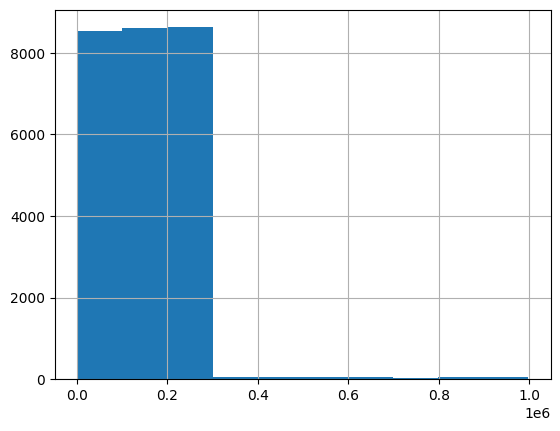

In [62]:
data['Amount'].hist()

(25754, 15)

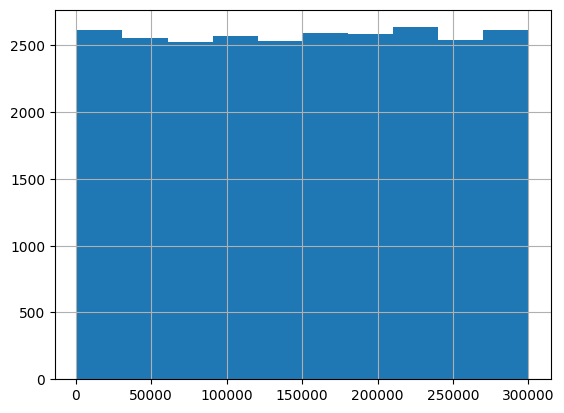

In [63]:
data = data[data['Amount'] < 300000]
data['Amount'].hist()
data.shape

In [64]:
import math

num_of_categories = 10;
max_amount = data['Amount'].max()
print(max_amount)
step_size = math.ceil((max_amount/num_of_categories)/10000)*10000
print(step_size)

299981
30000


In [65]:
def catergorize_amount(value):
    amount_cat = None
    for i in range(1,num_of_categories+1):
        thresh = i*step_size
        if(value > thresh):
            pass
        else:
            amount_cat = f"{thresh-step_size} - {thresh}"
            return amount_cat

In [66]:
data['Amount_Category']= data['Amount'].apply(catergorize_amount)

/tmp/ipykernel_91/573246793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Amount_Category']= data['Amount'].apply(catergorize_amount)


In [67]:
print(data[["Amount", "Amount_Category"]].head(10))

   Amount  Amount_Category
0   82475    60000 - 90000
1   32555    30000 - 60000
2  101738   90000 - 120000
3  123424  120000 - 150000
4  171574  150000 - 180000
5  100036   90000 - 120000
6  143250  120000 - 150000
7  150980  150000 - 180000
8  192247  180000 - 210000
9   67932    60000 - 90000


In [68]:
columns_to_drop = ["Card Type","Gender","DayName","Amount","Year","City","Day", "Month", "MonthSin","MonthCos","DaySin" ,"DayCos"]
data.drop(columns=columns_to_drop, inplace=True)
data.head()

/tmp/ipykernel_91/1758689583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=columns_to_drop, inplace=True)


,Exp Type,MonthName,City Tier,Amount_Category
0,Bills,October,Tier-1,60000 - 90000
1,Bills,August,Tier-3,30000 - 60000
2,Bills,August,Tier-1,90000 - 120000
3,Bills,April,Tier-3,120000 - 150000
4,Bills,May,Tier-1,150000 - 180000


In [69]:
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes

In [70]:
data.head()

,Exp Type,MonthName,City Tier,Amount_Category
0,Bills,October,Tier-1,60000 - 90000
1,Bills,August,Tier-3,30000 - 60000
2,Bills,August,Tier-1,90000 - 120000
3,Bills,April,Tier-3,120000 - 150000
4,Bills,May,Tier-1,150000 - 180000


In [71]:
print("Unique values in Exp Type: ", data['Exp Type'].unique())
print("Unique values in MonthName: ", data['MonthName'].unique())
print("Unique values in City Tier: ", data['City Tier'].unique())
print("Unique values in Amount_Category: ", data['Amount_Category'].unique())

Unique values in Exp Type:  ['Bills' 'Food' 'Entertainment' 'Grocery' 'Fuel' 'Travel']
Unique values in MonthName:  ['October' 'August' 'April' 'May' 'September' 'February' 'June' 'March'
 'December' 'July' 'November' 'January']
Unique values in City Tier:  ['Tier-1' 'Tier-3' 'Tier-2']
Unique values in Amount_Category:  ['60000 - 90000' '30000 - 60000' '90000 - 120000' '120000 - 150000'
 '150000 - 180000' '180000 - 210000' '270000 - 300000' '0 - 30000'
 '240000 - 270000' '210000 - 240000']


In [73]:

exp_type_encoding = {'Bills': 0, 'Food': 1, 'Entertainment': 2, 'Grocery': 3,
                     'Fuel': 4, 'Travel': 5}


month_encoding = { 'January': 0, 'February': 1, 'March': 2, 'April': 3, 
                  'May': 4, 'June': 5, 'July': 6, 'August': 7, 
                  'September': 8, 'October': 9, 'November': 10, 
                  'December': 11}


city_tier_encoding = {'Tier-1': 0, 'Tier-2': 1, 'Tier-3': 2}

amount_category_encoding = {
    '0 - 30000': 0, 
    '30000 - 60000': 1, 
    '60000 - 90000': 2,
    '90000 - 120000': 3, 
    '120000 - 150000': 4, 
    '150000 - 180000': 5,
    '180000 - 210000': 6, 
    '210000 - 240000': 7, 
    '240000 - 270000': 8,
    '270000 - 300000': 9
}

In [74]:
exp_type_decoding = {v: k for k, v in exp_type_encoding.items()}
month_decoding = {v: k for k, v in month_encoding.items()}
city_tier_decoding = {v: k for k, v in city_tier_encoding.items()}
amount_category_decoding = {v: k for k, v in amount_category_encoding.items()}

In [75]:
def apply_encoding(series, encoding_dict):
    return series.map(encoding_dict)

data_encoded = data.copy()
data_encoded['Exp Type'] = apply_encoding(data['Exp Type'], exp_type_encoding)
data_encoded['MonthName'] = apply_encoding(data['MonthName'], month_encoding)
data_encoded['City Tier'] = apply_encoding(data['City Tier'], city_tier_encoding)
data_encoded['Amount_Category'] = apply_encoding(data['Amount_Category'], amount_category_encoding)

data_encoded.head()

,Exp Type,MonthName,City Tier,Amount_Category
0,0,9,0,2
1,0,7,2,1
2,0,7,0,3
3,0,3,2,4
4,0,4,0,5


In [76]:
data_encoded.describe()

,Exp Type,MonthName,City Tier,Amount_Category
count,25754.000000,25754.000000,25754.000000,25754.000000
mean,2.095480,5.356372,0.822979,4.524307
std,1.484752,3.740366,0.911873,2.871234
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,2.000000
50%,2.000000,5.000000,0.000000,5.000000
75%,3.000000,9.000000,2.000000,7.000000
max,5.000000,11.000000,2.000000,9.000000


In [77]:
data_matrix = data_encoded.to_numpy()

In [78]:
data_matrix

array([[0, 9, 0, 2],
       [0, 7, 2, 1],
       [0, 7, 0, 3],
       ...,
       [5, 0, 0, 8],
       [5, 8, 1, 2],
       [0, 9, 0, 6]])

1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 78833.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 78833.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 78833.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 78833.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 78833.0
Best run was number 1
2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 72566.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2794, cost: 68797.0
Init: initializing centroids
Init: initializing clusters
Starting it

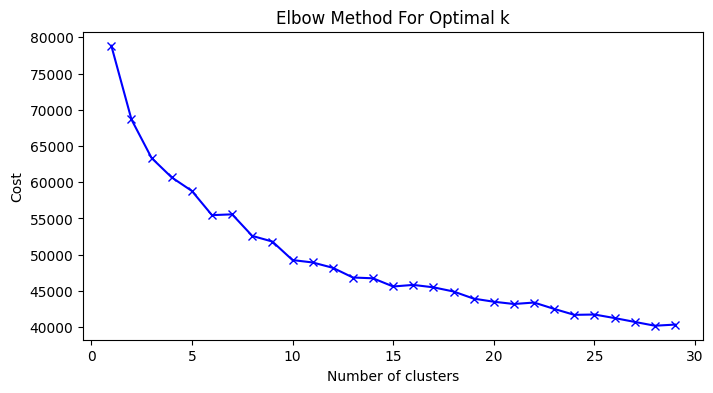

In [79]:
cost = []
K = range(1, 30)

for num_clusters in K:
    print(num_clusters)
    kmodes = KModes(n_clusters=num_clusters, init='Huang', n_init=5, verbose=1)
    kmodes.fit_predict(data_matrix)
    cost.append(kmodes.cost_)

# Plot the cost against the number of clusters
plt.figure(figsize=(8, 4))
plt.plot(K, cost, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [82]:
best_k = 10
kmodes = KModes(n_clusters=best_k, init='Huang', n_init=5, verbose=1)
clusters = kmodes.fit_predict(data_matrix)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1850, cost: 50866.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 53277.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1028, cost: 53094.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 50922.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 52318.0
Best run was number 1


In [86]:
cluster_centroids = kmodes.cluster_centroids_
for i, centroid in enumerate(cluster_centroids):
    print(f"Cluster {i}: {centroid}")

Cluster 0: [3 0 0 7]
Cluster 1: [0 4 1 6]
Cluster 2: [1 8 0 2]
Cluster 3: [ 4 11  2  6]
Cluster 4: [ 2 11  2  2]
Cluster 5: [3 3 2 9]
Cluster 6: [0 9 0 9]
Cluster 7: [2 5 1 8]
Cluster 8: [3 7 2 4]
Cluster 9: [1 3 2 8]


In [87]:
def decode_cluster_centroids(cluster_centroids, decoding_dicts):
    decoded_centroids = []
    for centroid in cluster_centroids:
        decoded_values = []
        for i, code in enumerate(centroid):
            decoded_values.append(decoding_dicts[i][code])
        decoded_centroids.append(decoded_values)
    return decoded_centroids

decoded_centroids = decode_cluster_centroids(cluster_centroids, [
    exp_type_decoding,month_decoding, city_tier_decoding, amount_category_decoding
])

for i, centroid in enumerate(decoded_centroids):
    print(f"Cluster {i}: {centroid}")

Cluster 0: ['Grocery', 'January', 'Tier-1', '210000 - 240000']
Cluster 1: ['Bills', 'May', 'Tier-2', '180000 - 210000']
Cluster 2: ['Food', 'September', 'Tier-1', '60000 - 90000']
Cluster 3: ['Fuel', 'December', 'Tier-3', '180000 - 210000']
Cluster 4: ['Entertainment', 'December', 'Tier-3', '60000 - 90000']
Cluster 5: ['Grocery', 'April', 'Tier-3', '270000 - 300000']
Cluster 6: ['Bills', 'October', 'Tier-1', '270000 - 300000']
Cluster 7: ['Entertainment', 'June', 'Tier-2', '240000 - 270000']
Cluster 8: ['Grocery', 'August', 'Tier-3', '120000 - 150000']
Cluster 9: ['Food', 'April', 'Tier-3', '240000 - 270000']


In [88]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(data_matrix, clusters, metric='euclidean')
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: -0.07960794749822102


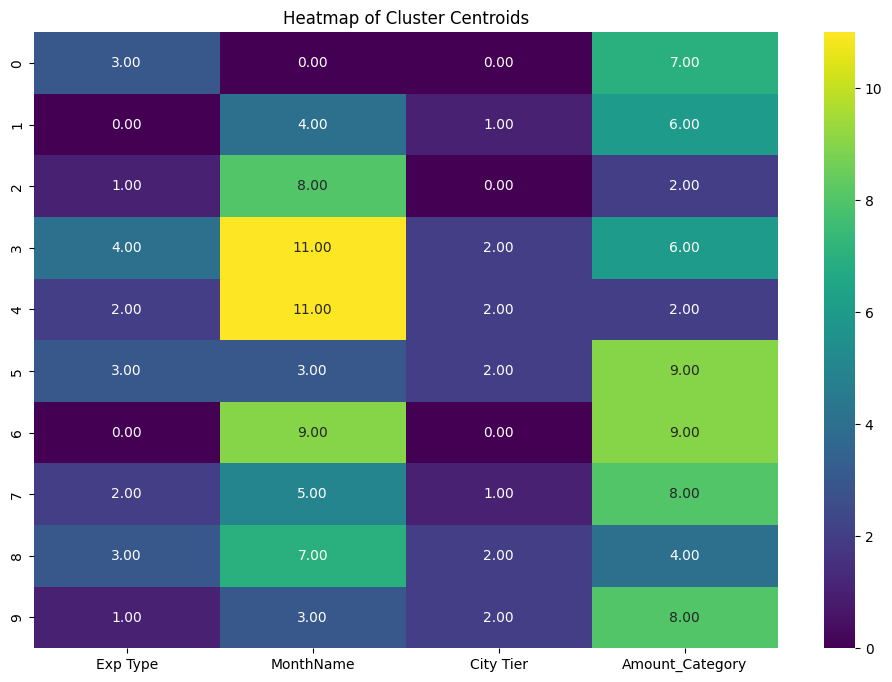

In [89]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centroids, annot=True, cmap='viridis', fmt='.2f', xticklabels=data.columns)
plt.title('Heatmap of Cluster Centroids')
plt.show()